# Интернет-магазин компьютерных игр
<br>
В данном проекте будет рассматриваться работа интернет-магазина, который реализует компьютерные игры по всему миру.
Для анализа нам представлены исторические данные о продажах игр, оценки пользоваетелй и экспертов, а также жанры и платформы (Xbos, PS, и т.д.).

Задачей проекта является - выявление закономерностей, определяющие успешность игр, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение общей информации

Для начала работы с данными и последующего их анализа, загрузим необходимые библиотеки

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings
#отключим уведомления об ограничениях
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [3]:
#откроем файл
try:
    df = pd.read_csv('C:/Users/datasets/games.csv', sep=',', decimal='.')  # Локальный путь
except:
    df = pd.read_csv('/datasets/games.csv', sep=',', decimal='.')  # Серверный путь

In [4]:
df.info();df.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
count,16713,16715,16446.000000,16713,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,10014,9949
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,E
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,2424,3990
mean,NaN,NaN,2006.484616,NaN,0.263377,0.145060,0.077617,0.047342,68.967679,NaN,NaN
std,NaN,NaN,5.877050,NaN,0.813604,0.503339,0.308853,0.186731,13.938165,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


### Вывод
Как видим из предварительного анализа:
1. Имеются пропущенные значения в столбцах: "Название игры", "Год выхода", "Жанр", оценки критиков и пользователей и "Рейтинг"
2. В наименованиях столбцов присутствует заглавные буквы, для упрощения обращения к ним, необходимо привести их к нижнему регистру
3. Необходимо скорректировать типы данных: а) по типам `object` можно сконвертировать по части данных в `category`, например по "Платформе", "Жанру" и "Рейтингу"; б) по столбцам "Год" и возможно по оценкам изменим тип данных на `int`; в) в столбце `user_score` присутствует значение `tbd`, необходимо перед обработкой типов заменить данное значение на `NaN` т.к. это значение будет определено в будущем




## Подготовка данных
На основе предварительного анализа на первом этапе, выполним обработку данных и подготовим их к исследовательскому анализу данных

### Изменение названий столбцов
С помощью `.str.lower()` заменим названия всех столбцов на нижний регистр

In [5]:
df.columns = df.columns.str.lower()

### Обработка пропусков


#### Столбец `name`
Так как наименование игр подобрать мы не сможем, удаляем их

In [6]:
df.dropna(subset = ['name'], inplace = True)

#### Столбец `year_of_release`
Количество отсутствующих значений не критично, удаляем данные строки

In [7]:
df.dropna(subset = ['year_of_release'], inplace = True)

#### Столбец `user_score`
Исправляем только значения `tbd` на `NaN`

In [8]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN).astype('float')

В следующих столбцах `critic_score`, `user_score`, `rating` пропуски мы не будем заполнять т.к. данные показатели нельзя подобрать расчетно и мы можем исказить анализ и выводы.

### Изменение типов данных
Перед тем как изменять типы данных, мы создадим функцию `mem_usage`, которая будет проверять занимаемую память таблицей

In [9]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f}".format(usage_mb)

Приступим к оптимизации, в коде подробно распишем каждый шаг в комментарии

In [10]:
#отобразим занимаемую память до оптимизации
print('Таблица до изменений типов данных занимает в памяти:',mem_usage(df),'МБ')
#оптимизация по типу данных 'object', что позволит сэкономить память т.к. уникальных значений в общей массе мало
df[['platform','genre','rating']] = df[['platform','genre','rating']].astype('category')
#изменение типа с float на int
df['year_of_release']=df['year_of_release'].astype('int')
#оптимизация типов float и int, понижение до минимальной разрядности
#---оптимизация
df[df.select_dtypes(include=['floating']).columns] = df.select_dtypes(include=['floating']).apply(pd.to_numeric,downcast='float')
df[df.select_dtypes(include=['integer']).columns] = df.select_dtypes(include=['integer']).apply(pd.to_numeric,downcast='integer')
#отобразим занимаемую память после оптимизации
print('Таблица после изменений типов данных занимает в памяти:',mem_usage(df),'МБ')

Таблица до изменений типов данных занимает в памяти: 4.97 МБ
Таблица после изменений типов данных занимает в памяти: 1.86 МБ


Обработав пропуски и типы данных мы смогли оптимизировать таблицу на 67%.

### Расчет суммарных продаж
Добавим столбец с суммарными продажами во всех регионах

In [11]:
df['sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

### Вывод
Мы провели предобработку данных, выполнив следующие процедуры:
1. привели названия столбцов к нижнему регистру
2. там где необходимо обработали пропуски
3. преобразовали данные в нужные типы
4. добавили расчетный столбец с суммарными продажами

Теперь мы можем приступать к исследованиям т.к. наши данные готовы к анализу и построению выводов.

## Исследовательский анализ данных
В данном блоке мы узнаем: 1) сколько было выпущено игр; 2) проанализируем продажи по платформам; 3) узнаем влияние отзывов пользователей и критиков на продажи; 4) узнаем наиболее прибыльные жанры игр. 
<br>Для этого мы будем строить диаграммы и на основании этого делать выводы.

### Количество выпущенных игр по годам
Построим столбчатую диаграмму по годам

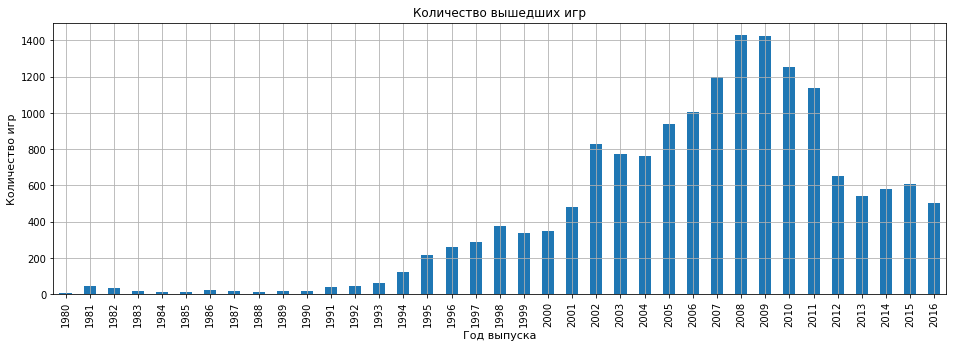

In [12]:
ax = df.groupby('year_of_release')['name'].count().plot(kind='bar', grid=True, figsize=(16, 5), title = 'Количество вышедших игр')
ax.set_ylabel("Количество игр", fontsize=11)
ax.set_xlabel("Год выпуска", fontsize=11)
plt.show()

Как видим из графика, пик выпуска игр наблюдался с 2007 по 2011, после произошел спад.
<br>По графику можно увидеть, что развитие игр более-менее активно началось с 1994 года, можно предположить с развитием компьютерных технологий. Наиболее активная фаза наблюдается с 2002 года. С 2012 года видим сокращение количества игр, на это могло повлиять много аспектов, например уход каких-либо платформ с рынка или развитие более качественных игр и фокус на определенные направления.

### Суммарные продажи по платформам

Построим диаграмму с продажами по всем платформам с сортировкой по возрастанию

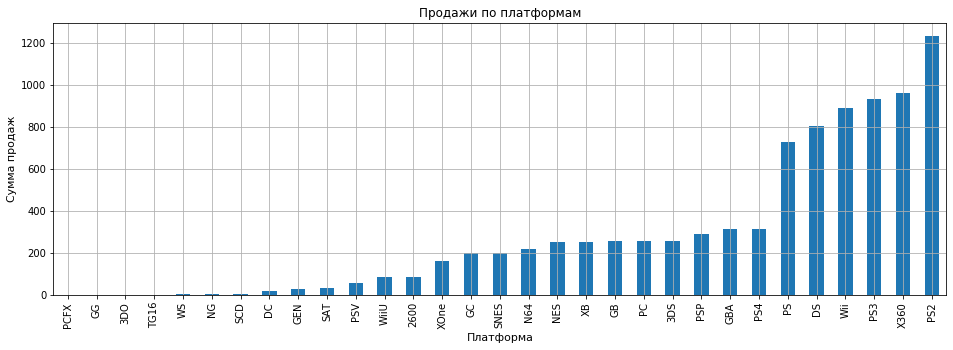

In [13]:
ax = df.groupby('platform')['sales'].sum().sort_values().plot(kind='bar', grid=True, figsize=(16, 5), title = 'Продажи по платформам')
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Платформа", fontsize=11)
plt.show()

Как видно из диаграммы, наибольшие продажи наблюдаются по платформам: PS,DS,Wii,PS3,X360,PS2.


### Продажи у популярных платформ по годам
Рассмотрим подробнее данные платформы по годам и проверим, какой срок существует новая платформа на рынке

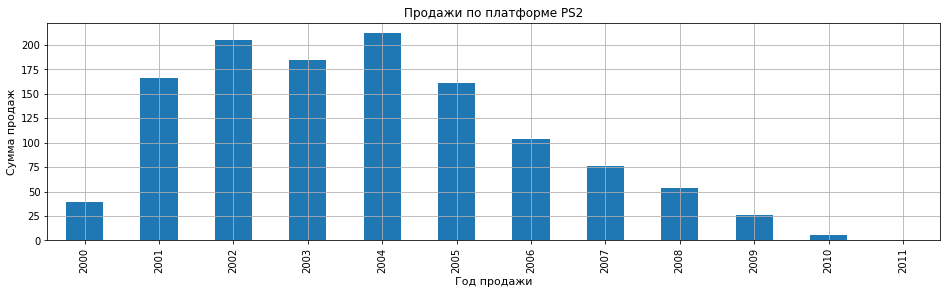

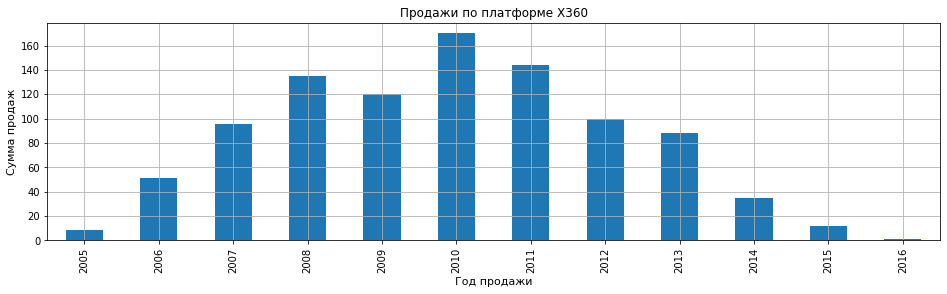

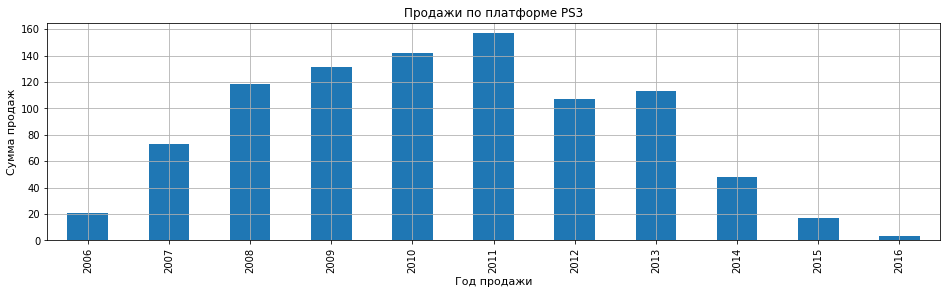

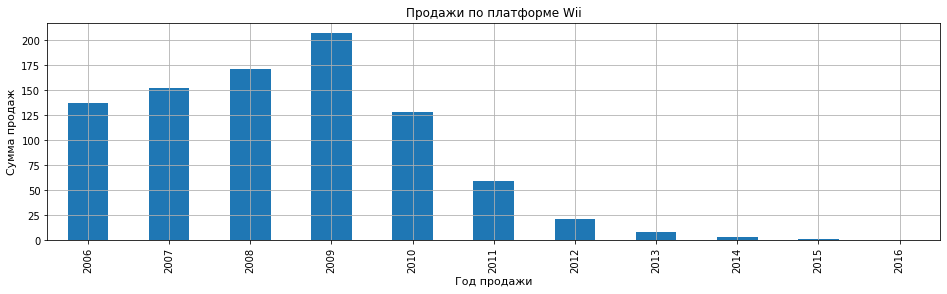

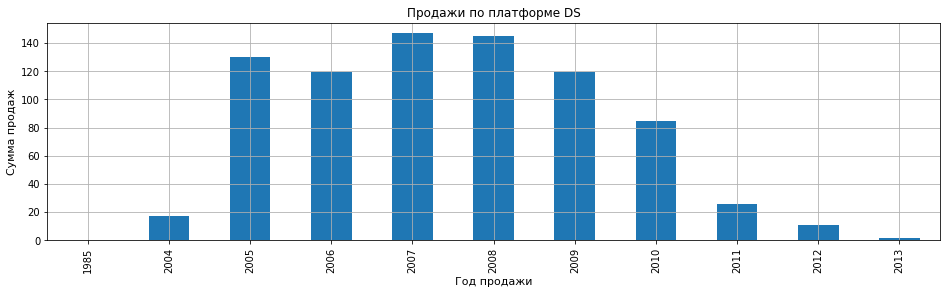

In [14]:
for col in df.groupby('platform')['sales'].sum().sort_values(ascending=False).head(5).index:
  ax = df[df['platform']==col].groupby('year_of_release')['sales'].sum().plot(kind='bar', grid=True, figsize=(16, 4), title = 'Продажи по платформе '+col)
  ax.set_ylabel("Сумма продаж", fontsize=11)
  ax.set_xlabel("Год продажи", fontsize=11)
  plt.show()

Как видно из графиков по продажам в разрезе самых продаваемых платформ, срок активной жизни платформ в среднем составляет 6 лет, что вполне логично, технологии развиваются стремительно и новые игры становятся все более требовательными, для этого приходится создавать новые консоли с наиболее мощными начинками.

Так как мы определили, что средний срок активной жизни платформы составляет 6 лет, то будем рассматривать в анализе `актуальный период` как половину - 3 года, чтобы наиболее свежую информацию в предпочтениях пользователей т.е. с 2014 года, что послужит опорой для построения прогноза на 2017 год.

In [15]:
#далее в работе будем рассматривать данные с 2014 года
df = df[df['year_of_release']>=2014]
df = df[df['sales']>0].reset_index(drop=True)
#так как бы работаем с категориальным типом данных, необходимо после группировки сбросить неиспользуемые категории
df['platform'] = df['platform'].cat.remove_unused_categories()

### Определение потенциально прибыльных платформ

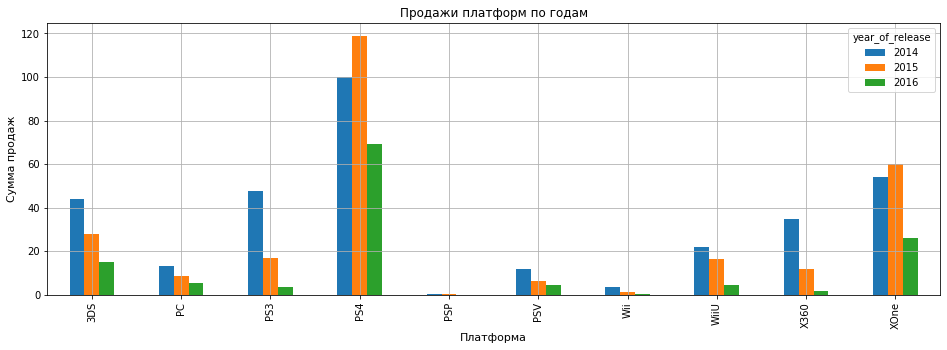

In [16]:
#таблица под график
df_act = df.groupby(['platform','year_of_release'])['sales'].sum().reset_index()
#так как бы работаем с категориальным типом данных, необходимо после группировки сбросить неиспользуемые категории
df_act['platform'] = df_act['platform'].cat.remove_unused_categories()
#трансформируем таблицу для отображения столбчатой диаграммы по каждой платформе по
ax_data = df_act.pivot(index='platform', columns='year_of_release', values='sales')
#построим столбчатую диаграмму
ax = ax_data.plot(kind='bar', grid=True, figsize=(16, 5), title = 'Продажи платформ по годам')
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Платформа", fontsize=11)
plt.show()

Как видим из наглядного графика, что наиболее высокие продажи наблюдались больше всего по `PS3`, `PS4` и `X360`, но обратим вниманием, что по `PS3` и `X360` продажи на 2016 год крайне малы. Для наших целей нам необходимо отобрать наиболее потенциальные платформы, поэтому возьмем на анлиз платформы `3DS`, `PS4` и `XOne`, где две последние относительно новые т.к. вышли в 2013 и могут показать большие продажи.

### "Ящик с усами" по глобальным продажам игр по платформам

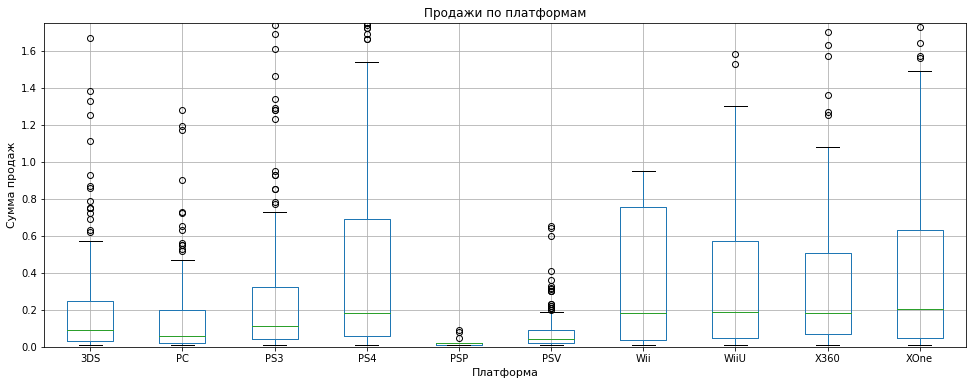

In [18]:
#построим диаграмму
ax = df.boxplot(column = 'sales', by='platform', figsize=(16,6))
plt.suptitle("")
ax.set_title("Продажи по платформам", fontsize=12)
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Платформа", fontsize=11)
ax.set_ylim([0, 1.75])
plt.show()

Наибольшие продажи по медиане наблюдаются у `XOne`,`PS4`,`X360` и `Wii`, а также у `3DS` и `PS3`
<br>Практически у всех платформ присутствуют выбросы, что говорит о наличии аномально высоких и низких продажах.

### Влияние на продажи отзывов пользователей и критиков
Для выполнения данного исследования, построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.
<br>Анализ будем выполнять по наиболее популярной платформе **`PS4`**

#### Диаграммы рассеяния - оценки критиков

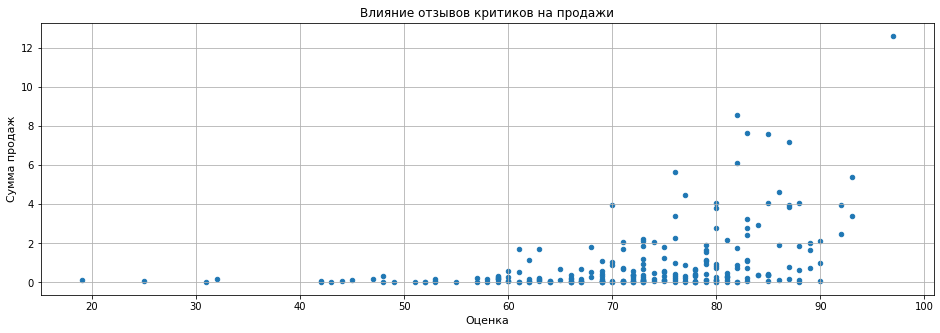

In [19]:
#построение диаграммы
ax = df[df['platform']=='PS4'].plot(x='critic_score', y='sales', kind='scatter', figsize=(16, 5), grid=True)
ax.set_title("Влияние отзывов критиков на продажи", fontsize=12)
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Оценка", fontsize=11)
plt.show()

Как видим из графика, наличие высоких оценок от критиков оказывает влияние на продажи игр

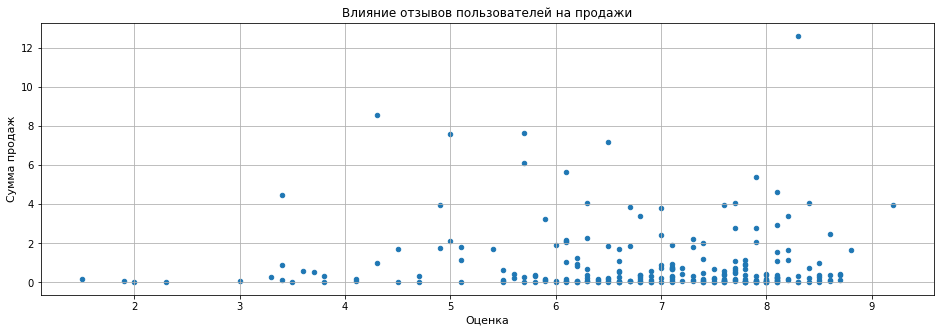

In [20]:
#построение диаграммы
ax = df[df['platform']=='PS4'].plot(x='user_score', y='sales', kind='scatter', figsize=(16, 5), grid=True)
ax.set_title("Влияние отзывов пользователей на продажи", fontsize=12)
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Оценка", fontsize=11)
plt.show()

В отличие от критиков, на данной диаграмме мы видим, что отзывы пользователей не оказывают весомого влияния на продажи игр

#### Корреляция между отзывами и продажами
Построим функцию, которая будет рассчитывать коэффициент корреляции между заданными нами показателями

In [21]:
#функция расчета корреляции
def check_corr(pltfrm,var):
  x = df[df['platform']==pltfrm][var].corr(df[df['platform']==pltfrm]['sales'])
  print('Корреляция между продажами и показателем "' + var +'" составила - {:.2}'.format(x))

In [22]:
check_corr('PS4','critic_score')
check_corr('PS4','user_score')

Корреляция между продажами и показателем "critic_score" составила - 0.4
Корреляция между продажами и показателем "user_score" составила - -0.04


На основании рассчитаных показателей, мы лишь подтверждаем наши выводы из диаграмм рассеивания, что оценка критиков иммет более высокий уровень корреляции и по отзывам пользователей наоборот наблюдается крайне слабая корреляция.

#### Соотнесем выводы с продажами игр на других платформах

In [23]:
#перебираем популярные платформы, кроме PS3 т.к. мы ее рассматривали выше
for col in df[df['platform']!='PS4'].groupby('platform')['sales'].sum().sort_values(ascending=False).head(5).index:
  print(col)
  check_corr(col,'critic_score')
  check_corr(col,'user_score')

XOne
Корреляция между продажами и показателем "critic_score" составила - 0.43
Корреляция между продажами и показателем "user_score" составила - -0.07
3DS
Корреляция между продажами и показателем "critic_score" составила - 0.31
Корреляция между продажами и показателем "user_score" составила - 0.22
PS3
Корреляция между продажами и показателем "critic_score" составила - 0.45
Корреляция между продажами и показателем "user_score" составила - -0.17
X360
Корреляция между продажами и показателем "critic_score" составила - 0.53
Корреляция между продажами и показателем "user_score" составила - -0.14
WiiU
Корреляция между продажами и показателем "critic_score" составила - 0.37
Корреляция между продажами и показателем "user_score" составила - 0.41


Как видно из рассчитанных показателей, оценки критиков всегда имели большее влияние на продажи игр, нежели оценки пользователей, кроме платформы `WiiU`, где корреляция по оценкам пользователей немного выше.

### Общее распределение игр по жанрам


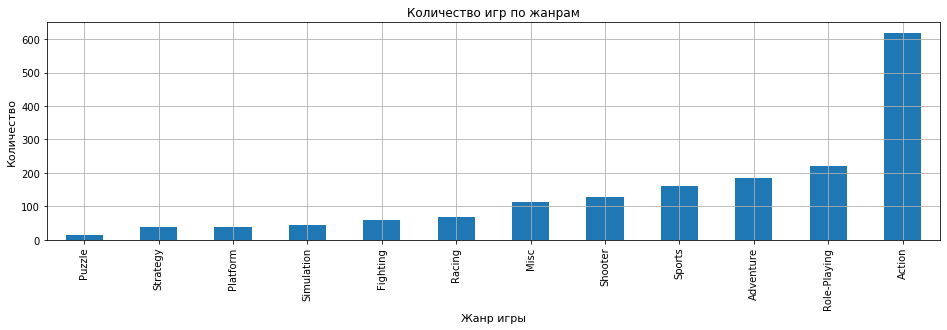

In [24]:
#построим диаграмму по количеству игр в разрезе жанров
ax = df.groupby('genre')['name'].count().sort_values().plot(kind='bar', grid=True, figsize=(16, 4), title = 'Количество игр по жанрам')
ax.set_ylabel("Количество", fontsize=11)
ax.set_xlabel("Жанр игры", fontsize=11)
plt.show()

Как видно из диаграммы, наиболее часто выпускаемыми играми являются с жанрами: `Action`,`Role-Playing`,`Adventure`. Наименьшее количество игр на рынке с жанрами: `Puzzle` и `Strategy`, что вполне звучит реалистично. 

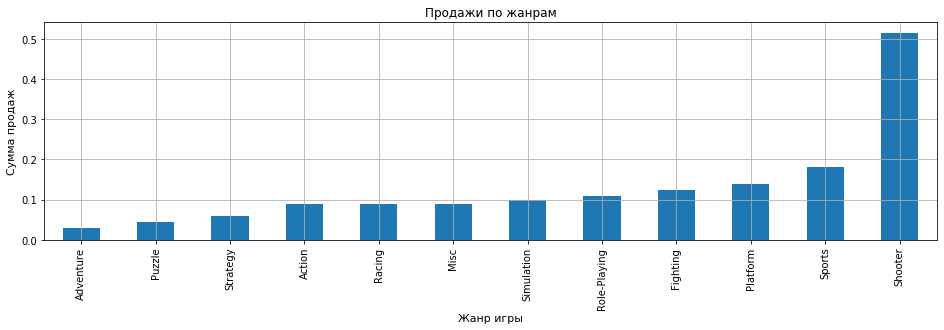

In [25]:
#построим диаграмму по продажам в разрезе жанров и рассмотрим по медиане, чтобы исключить влияние хитов и большого объема игр в одном жанре
ax = df.groupby('genre')['sales'].median().sort_values().plot(kind='bar', grid=True, figsize=(16, 4), title = 'Продажи по жанрам')
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Жанр игры", fontsize=11)
plt.show()

При просмотре медианных продаж, мы видим другую картину нежели чем в количественном выражении. Если по количеству наиболее популярным жанром был `Action`, то в продажах первое место с большим отрывом ото всех занимает `Shooter`, и затем идут `Sports`,`Platform` и остальные.

### Вывод
На основе проведенного исследования мы выяснили:
1. По количеству выпущенных игр лидирует жанр `Action`, но при этом жанр `Shooter` лидирует в продажах
2. Наиболее популярными платформами, которые вероятнее всего будут актуальными в 2017 году: PS4, XOne и 3DS
3. Оценки критиков оказывают большее влияние на продажи игр, чем оценки пользователей.

## Портрет пользователя каждого региона
На данном этапе мы рассмотрим по каждому региону `NA`,`EU`,`JP` продажи по платформам, определим самые популярные жарны и оценим влияние рейтинга `ESRB` на продажи данных регионов. Так как мы ранее отметили, что актуальный период у нас является 3 последних лет, то для большей реалистичности будем проводить анализ платформ с 2014 года.

### ТОП 5 популярных платформ по регионам

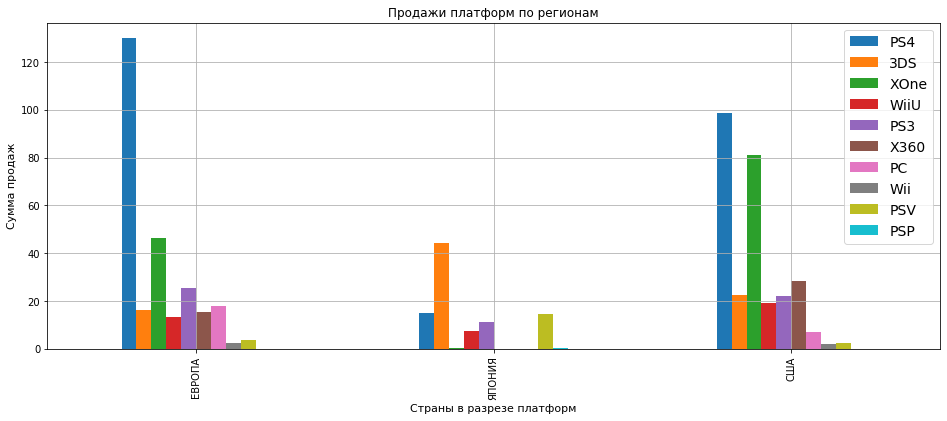

In [61]:
#сформируем таблицу
df_act = df.melt(id_vars=['platform'], value_vars=['na_sales','eu_sales','jp_sales'],var_name='country', value_name='sales').groupby(['platform','country']).sum().reset_index()
df_act = df_act.pivot_table(index='country', columns='platform', values='sales')
df_act.columns = df_act.columns.astype(str)
df_act = df_act.reset_index()
#строим график
ax = df_act.plot(kind='bar', x='country',y=df.platform.unique(), grid=True, figsize=(16, 6), title = 'Продажи платформ по регионам')
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Страны в разрезе платформ", fontsize=11)
ax.legend(loc=1, prop={'size': 14})
ax.set_xticklabels(['ЕВРОПА','ЯПОНИЯ','США'])
plt.show()

На основе данной диаграммы, можно сделать следующие выводы:
1. в Северной Америке популярными ТОП5 по убыванию являются платформы: `PS4`,`XOne`,`X360`,`3DS` и `PS3`.
2. в Европе ТОП5 популярными являются `PS4`,`XOne`,`PS3`,`PC` и `3DS`.
3. в Японии картина противоположная Европе и Америке, самой популярной платформой является `3DS`, далее в ТОП5 идут `PS4`,`PS3`,`PSV` и `Wii`. Также стоит обратить внимание, что на данном рынке практически отсутствует XBox.

### ТОП 5 популярных жанров по регионам

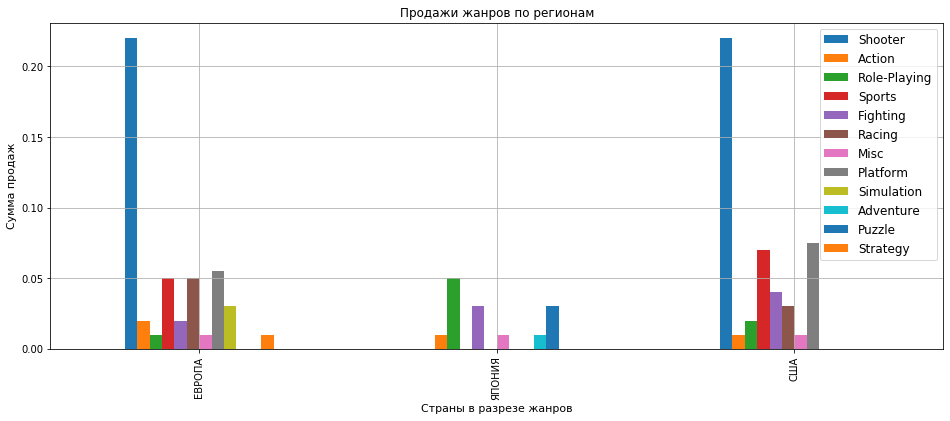

In [29]:
#сформируем таблицу по медиане, чтобы исключить влияние хитов и большого объема игр в одном жанре
df_act = df.melt(id_vars=['genre'], value_vars=['na_sales','eu_sales','jp_sales'],var_name='country', value_name='sales').groupby(['genre','country']).median().reset_index()
df_act = df_act.pivot_table(index='country', columns='genre', values='sales')
df_act.columns = df_act.columns.astype(str)
df_act = df_act.reset_index()
#строим график
ax = df_act.plot(kind='bar', x='country',y=df.genre.unique(), grid=True, figsize=(16, 6), title = 'Продажи жанров по регионам')
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Страны в разрезе жанров", fontsize=11)
ax.legend(loc=0, prop={'size': 12})
ax.set_xticklabels(['ЕВРОПА','ЯПОНИЯ','США'])
plt.show()

На основе данной диаграммы, можно сделать следующие выводы:
1. в Северной Америке наиболее популярными ТОП5 жанрами являются: `Shooter`, `Platfrom`,`Sports`,`Fighting` и `Racing`
2. в Европе наблюдается похожая ситуация как в США в предпочтениях пользователей по жанрам `Shooter`, `Platfrom`,`Sports`,`Fighting`, кроме последнего, здесь вместо `Racing` более популярна `Simulation`
3. в Японии другие предпочтения в жанрах, в ТОП5 входит: `Role-Playing`,`Fighting`,`Puzzle`,`Misc` и `Adventure`.

Таким образом, вкусы пользователей Европы и Америки схожи, что нельзя сказать о Японцах, которые предпочитают другие направления в играх.

### Влияние рейтинга ESRB на продажи 

В системе ESRB существует следующее разделение оценок:
1. «M» («Mature») — «Для взрослых 18+»
2. «E» («Everyone») — «Для всех 6+»
3. «E10+» («Everyone 10 and older») — «Для всех 10+»
4. «T» («Teen») — «Подростки 13+»
5. «EC» («Early childhood») — «Для детей 3+»
6. «RP» («Rating Pending») — «Рейтинг ожидается».

Для удобства анализа данных, создадим новый столбец, где укажем описание рейтинга и эти данные отразим на диаграмме.

In [30]:
#функция определения возрастной группы
def rat_group(rating):
    if rating == 'M': return 'Взрослые 18+'
    if rating == 'E': return 'Все 6+'
    if rating == 'E10+': return 'Все 10+'
    if rating == 'EC': return 'Дети 3+'
    if rating == 'T': return 'Подростки 13+'
    return 'Не указана'
#создаем новый столбец
df['rat_group'] = df['rating'].apply(rat_group)

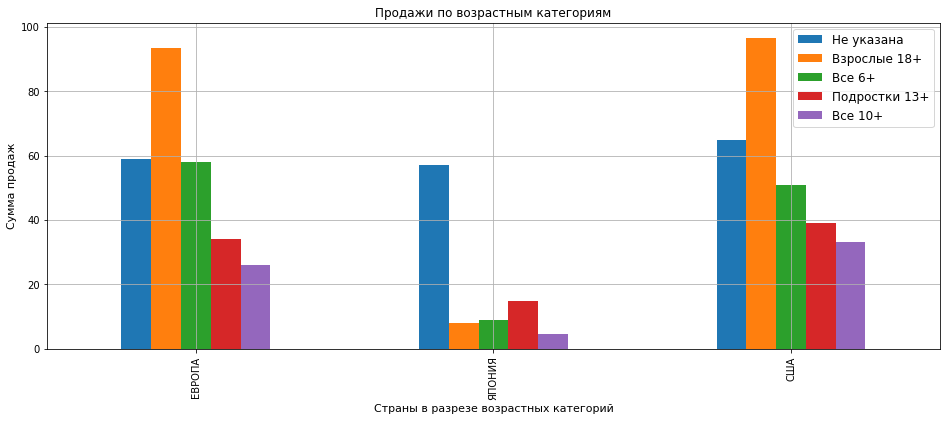

In [31]:
#сформируем таблицу, учитываем только группы ESRB т.к. оцениваем именно их влияние
df['rat_group'] = df['rat_group'].fillna('Не указана') #заполняем пустые
df_act = df.melt(id_vars=['rat_group'], value_vars=['na_sales','eu_sales','jp_sales'],var_name='country', value_name='sales').groupby(['rat_group','country']).sum().reset_index()
df_act = df_act.pivot_table(index='country', columns='rat_group', values='sales')
df_act.columns = df_act.columns.astype(str)
df_act = df_act.reset_index()
#строим график
ax = df_act.plot(kind='bar', x='country',y=df.rat_group.unique(), grid=True, figsize=(16, 6), title = 'Продажи по возрастным категориям')
ax.set_ylabel("Сумма продаж", fontsize=11)
ax.set_xlabel("Страны в разрезе возрастных категорий", fontsize=11)
ax.legend(loc=0, prop={'size': 12})
ax.set_xticklabels(['ЕВРОПА','ЯПОНИЯ','США'])
plt.show()

Как видим из графика:
1. в Америке по оценке ESRB наиболее продаваемые игры с возрастным цензом `18+`, далее идут игры для детей `6+` и `10+`, игры без оценок занимают такое же место как и `для всех 6+`
2. в Европе по оценке ESRB аналогичная ситуация как и в Америке, игры без оценок находятся на втором месте
3. в Японии по оценке ESRB больше игр продаются с категорией `6+`, затем идут игры для подростков `13+` и только потом игры для взрослых `18+`, также обращается внимание на игры без оценок, они занимают большую часть.

Таким образом, поведение в предпочтениях пользователей Европы и Америки похожи, что нельзя сказать о Японии, где наблюдается противоположная ситуация.

### Вывод


На основании изучения портрета пользователей в регионах, можно сделать следующие выводы:
1. по платформам Америка и Европа схожи, Япония отличается от большинства и предпочитает платформу `3DS`, но также и использует `PS4` и `PS3`.
2. по жанрам похожая картина, Америка и Европа предпочитают жанры `Shooter`, `Platfrom` и `Sports`, а в Японии наибольшей популярностью пользуется жанр `Role-Playing` и `Fighting`
3. исходя из возрастных ограничений по системе `ESRB` в Европе и Америке большинство предпочитает игры `18+`, что вполне логично т.к. в предпочитаемыми ими жанрах часто показывается кровь и на это накладываются ограничения. В Японии немного другая картина, предпочтения отдаются играм `13+` и `для всех 6+`, при этом большая часть игр не имеют возрастных категорий, возможно по причине что в Японии действует другое рейтинговое агенство.

## Проверка гипотез
Для удобства проверки гипотез создадим функцию, которая будет выдавать результат по заранее представленным аналитикам. Используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам `scipy.stats.ttest_ind (array1, array2,equal_var)`

In [32]:
def hyp_test(col_name,condition_1,condition_2):
    #создадим 2 массива с необходимым нам столбцов и условиями
    rat_1 = df[df[col_name]==condition_1]['user_score'].dropna()
    rat_2 = df[df[col_name]==condition_2]['user_score'].dropna()
    # критический уровень статистической значимости
    alpha = .05
    # результаты расчета
    results = st.ttest_ind(rat_1, rat_2)
    #отразим p-значение
    print('p-значение: ', results.pvalue)
    #проверка
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")  

### Гипотеза 1
Проверим, различаются ли средние пользовательские рейтинги платформ `Xbox One` и `PC`, для этого сформируем нулевую и альтернативную гипотезы:
* **Н0** - средние пользовательские рейтинги платформ `Xbox One` и `PC` равны
* **Н1** - средние пользовательские рейтинги платформ `Xbox One` и `PC` не равны

In [33]:
hyp_test ('platform','XOne','PC')

p-значение:  0.10450648637161196
Не получилось отвергнуть нулевую гипотезу


По результатам проведенной проверки гипотезы, мы можем предположить, что средние пользовательские оценки по данным платформам очень схожи.

### Гипотеза 2
Проверим, различаются ли средние пользовательские рейтинги жанров `Action` и `Sports`, для этого сформируем нулевую и альтернативную гипотезы:
* **Н0** - средние пользовательские рейтинги жанров `Action` и `Sports` равны
* **Н1** - средние пользовательские рейтинги жанров `Action` и `Sports` не равны

In [34]:
hyp_test ('genre','Action','Sports')

p-значение:  2.871148452488903e-19
Отвергаем нулевую гипотезу


Таким образом, по результату проверки гипотезы, мы действительно можем предположить, что жанры `Action` и `Sports` имеют разные пользовательские рейтинги.

## Общий вывод

Мы проанализировали исторические данные по продажам игр, где смогли ознакомиться с существующим в мире перечне игр и используемых для этого платформ, и также изучили поведение пользователей и их предпочтения, и готовы сделать выводы согласно задаче нашего проекта и выбрать потенциально популярный продукт, что позволит спланировать корректно рекламную компанию.
<br>Для этого мы выполнили ряд процедур:
1. Ознакомились с общей информацией
2. Подготовили данные к анализу, а именно: а) изменили наименования столбцов к нижнему регистру; б) обработали пропуски, где это было необходимо; в) изменили и оптимизировали типы данных, что позволило нам сэкономить память занимаемую таблицами; г) рассчитали суммарные продажи.

По итогам обработки мы приступили к исследованиям, где сделали следующие выводы и наблюдения:
1. количество выпущенных игр заметно стало расти с 1994 года и с 2002 года показало резкий рост, что указывает на развитие технологий и их доступность, ведь если они доступнее, то и пользователей этих игр также становится больше
2. за всю историю наблюдений наиболее популярными платформами оказались PS2 и X360
3. активная жизнь популярных платформ в среднем составила 6 лет, но для анализа мы взяли период 3 последних года, чтобы корректно спрогнозировать потенциально популярный продукт на 2017 год
4. наиболее популярными и перспективными платформами на 2016 год оказались `3DS`, `PS4` и `XOne`
5. оценки критиков оказывают больше влияния на продажи игр, нежели чем оценки пользователей
6. наиболее популярными жанрами являются `Shooter`, `Platfrom`,`Sports`, `Role-Playing` и `Fighting`, что позволяет нам понять в каком направлении делать ставки
7. при проверке гипотез, мы выявили, что пользовательские рейтинги между платформами `PC` и `Xbox One` не отличаются существенно. Но при сравнении пользовательских рейтингов жанров `Action` и `Sports` с помощью проверки гипотезы выявили, что они отличаются.

Таким образом, мы выяснили, что на 2017 год стоит делать ставки на платформы `3DS`, `PS4` и `XOne` т.к. они перспективны, особенно последние 2 т.к. они развиваются и пришли на замену старых поколений. Среди жанров стоит обращать внимание на `Shooter`, `Platfrom`,`Sports`, `Role-Playing` и `Fighting` т.к. имеют высокий спрос.
<br>Но не стоит также забывать и про территориальную принадлежность пользователей, а именно портрет пользователя т.к. у разных континентов могут быть разные предпочтения. Так например в Японии больший акцент стоит делать на платформу Nintendo и жанр `Role-Playing` и `Fighting`, а в Европе и Америке в сторону `XBox` и `Playstation` с жарнами `Shooter`, `Platfrom` и `Sports`.